In [1]:
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [2]:
# Load data
df = pd.read_csv('../data/raw/Walmart_Sales.csv')

# Convert date
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Sort by store and date
df = df.sort_values(['Store', 'Date']).reset_index(drop=True)

# Selected stores from previous analysis
SELECTED_STORES = [20, 40, 15]

# Filter to selected stores
df_selected = df[df['Store'].isin(SELECTED_STORES)].copy()

print(f"Original dataset: {df.shape}")
print(f"Selected stores dataset: {df_selected.shape}")
print(f"Stores: {SELECTED_STORES}")
print(f"Date range: {df_selected['Date'].min()} to {df_selected['Date'].max()}")

Original dataset: (6435, 8)
Selected stores dataset: (429, 8)
Stores: [20, 40, 15]
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00


In [3]:
# Extract temporal features
df_selected['Year'] = df_selected['Date'].dt.year
df_selected['Month'] = df_selected['Date'].dt.month
df_selected['Week'] = df_selected['Date'].dt.isocalendar().week
df_selected['Quarter'] = df_selected['Date'].dt.quarter
df_selected['DayOfYear'] = df_selected['Date'].dt.dayofyear
df_selected['WeekOfYear'] = df_selected['Date'].dt.isocalendar().week

# Create cyclical features (important for capturing seasonality)
# Month as sin/cos to capture cyclical nature
df_selected['Month_sin'] = np.sin(2 * np.pi * df_selected['Month'] / 12)
df_selected['Month_cos'] = np.cos(2 * np.pi * df_selected['Month'] / 12)

# Week as sin/cos
df_selected['Week_sin'] = np.sin(2 * np.pi * df_selected['WeekOfYear'] / 52)
df_selected['Week_cos'] = np.cos(2 * np.pi * df_selected['WeekOfYear'] / 52)

print("Temporal features created:")
print(df_selected[['Date', 'Year', 'Month', 'Quarter', 'Month_sin', 'Month_cos']].head(10))

Temporal features created:
           Date  Year  Month  Quarter  Month_sin     Month_cos
2002 2010-02-05  2010      2        1   0.866025  5.000000e-01
2003 2010-02-12  2010      2        1   0.866025  5.000000e-01
2004 2010-02-19  2010      2        1   0.866025  5.000000e-01
2005 2010-02-26  2010      2        1   0.866025  5.000000e-01
2006 2010-03-05  2010      3        1   1.000000  6.123234e-17
2007 2010-03-12  2010      3        1   1.000000  6.123234e-17
2008 2010-03-19  2010      3        1   1.000000  6.123234e-17
2009 2010-03-26  2010      3        1   1.000000  6.123234e-17
2010 2010-04-02  2010      4        2   0.866025 -5.000000e-01
2011 2010-04-09  2010      4        2   0.866025 -5.000000e-01


In [4]:
# Create lag features (previous weeks' sales)
# These capture autocorrelation - past sales predict future sales

def create_lag_features(df, target_col='Weekly_Sales', lags=[1, 2, 3, 4, 8, 12]):
    """
    Create lag features for time series forecasting.
    
    Args:
        df: DataFrame with time series data (must be sorted by Store and Date)
        target_col: Column to create lags for
        lags: List of lag periods (in weeks)
    
    Returns:
        DataFrame with lag features added
    """
    df = df.copy()
    
    for lag in lags:
        df[f'Sales_Lag_{lag}'] = df.groupby('Store')[target_col].shift(lag)
    
    return df

# Apply lag features
df_selected = create_lag_features(df_selected, lags=[1, 2, 3, 4, 8, 12])

print("Lag features created:")
print("\nExample for Store 20:")
sample = df_selected[df_selected['Store'] == 20][['Date', 'Weekly_Sales', 
                                                     'Sales_Lag_1', 'Sales_Lag_2', 
                                                     'Sales_Lag_4']].head(15)
print(sample)

print(f"\nMissing values after lag creation:")
print(df_selected[['Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_4', 'Sales_Lag_12']].isnull().sum())

Lag features created:

Example for Store 20:
           Date  Weekly_Sales  Sales_Lag_1  Sales_Lag_2  Sales_Lag_4
2717 2010-02-05    2401395.47          NaN          NaN          NaN
2718 2010-02-12    2109107.90   2401395.47          NaN          NaN
2719 2010-02-19    2161549.76   2109107.90   2401395.47          NaN
2720 2010-02-26    1898193.95   2161549.76   2109107.90          NaN
2721 2010-03-05    2119213.72   1898193.95   2161549.76   2401395.47
2722 2010-03-12    2010974.84   2119213.72   1898193.95   2109107.90
2723 2010-03-19    1951848.43   2010974.84   2119213.72   2161549.76
2724 2010-03-26    1894742.95   1951848.43   2010974.84   1898193.95
2725 2010-04-02    2405395.22   1894742.95   1951848.43   2119213.72
2726 2010-04-09    2007796.26   2405395.22   1894742.95   2010974.84
2727 2010-04-16    1985784.59   2007796.26   2405395.22   1951848.43
2728 2010-04-23    1878862.42   1985784.59   2007796.26   1894742.95
2729 2010-04-30    1919053.21   1878862.42   1985784.59   

In [5]:
# Create rolling window features
# These smooth out noise and capture trends

def create_rolling_features(df, target_col='Weekly_Sales', windows=[4, 8, 12]):
    """
    Create rolling statistics (mean, std) for time series.
    
    Args:
        df: DataFrame with time series data
        target_col: Column to calculate rolling stats for
        windows: List of window sizes (in weeks)
    
    Returns:
        DataFrame with rolling features added
    """
    df = df.copy()
    
    for window in windows:
        # Rolling mean
        df[f'Sales_RollMean_{window}'] = df.groupby('Store')[target_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        
        # Rolling std (volatility measure)
        df[f'Sales_RollStd_{window}'] = df.groupby('Store')[target_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )
    
    return df

# Apply rolling features
df_selected = create_rolling_features(df_selected, windows=[4, 8, 12])

print("Rolling features created:")
print("\nExample for Store 20:")
sample = df_selected[df_selected['Store'] == 20][['Date', 'Weekly_Sales', 
                                                     'Sales_RollMean_4', 
                                                     'Sales_RollMean_12']].head(15)
print(sample)

Rolling features created:

Example for Store 20:
           Date  Weekly_Sales  Sales_RollMean_4  Sales_RollMean_12
2717 2010-02-05    2401395.47      2.401395e+06       2.401395e+06
2718 2010-02-12    2109107.90      2.255252e+06       2.255252e+06
2719 2010-02-19    2161549.76      2.224018e+06       2.224018e+06
2720 2010-02-26    1898193.95      2.142562e+06       2.142562e+06
2721 2010-03-05    2119213.72      2.072016e+06       2.137892e+06
2722 2010-03-12    2010974.84      2.047483e+06       2.116739e+06
2723 2010-03-19    1951848.43      1.995058e+06       2.093183e+06
2724 2010-03-26    1894742.95      1.994195e+06       2.068378e+06
2725 2010-04-02    2405395.22      2.065740e+06       2.105825e+06
2726 2010-04-09    2007796.26      2.064946e+06       2.096022e+06
2727 2010-04-16    1985784.59      2.073430e+06       2.086000e+06
2728 2010-04-23    1878862.42      2.069460e+06       2.068739e+06
2729 2010-04-30    1919053.21      1.947874e+06       2.028544e+06
2730 2010-05-

In [6]:
# Create trend and momentum features

def create_trend_features(df, target_col='Weekly_Sales'):
    """
    Create features capturing trends and momentum.
    """
    df = df.copy()
    
    # Week-over-week change
    df['Sales_WoW_Change'] = df.groupby('Store')[target_col].pct_change(periods=1)
    
    # 4-week momentum (comparing current to 4 weeks ago)
    df['Sales_Momentum_4w'] = df.groupby('Store')[target_col].pct_change(periods=4)
    
    # Difference from 4-week rolling average
    df['Sales_Diff_RollMean_4'] = df[target_col] - df['Sales_RollMean_4']
    
    return df

df_selected = create_trend_features(df_selected)

print("Trend features created:")
print("\nSample statistics:")
print(df_selected[['Sales_WoW_Change', 'Sales_Momentum_4w', 'Sales_Diff_RollMean_4']].describe())

Trend features created:

Sample statistics:
       Sales_WoW_Change  Sales_Momentum_4w  Sales_Diff_RollMean_4
count        426.000000         417.000000             429.000000
mean           0.007897           0.012709           -1537.259472
std            0.131426           0.160867          145812.479267
min           -0.602611          -0.643861         -984697.327500
25%           -0.049159          -0.058752          -43354.422500
50%           -0.004184           0.004481           -3292.370000
75%            0.053134           0.072803           39636.005000
max            0.841528           0.871998          828173.967500


Holiday features created:

Holiday distribution:
Regular holidays: 30 weeks
Major holidays: 36 weeks
Post-holiday: 24 weeks
Pre-holiday: 39 weeks


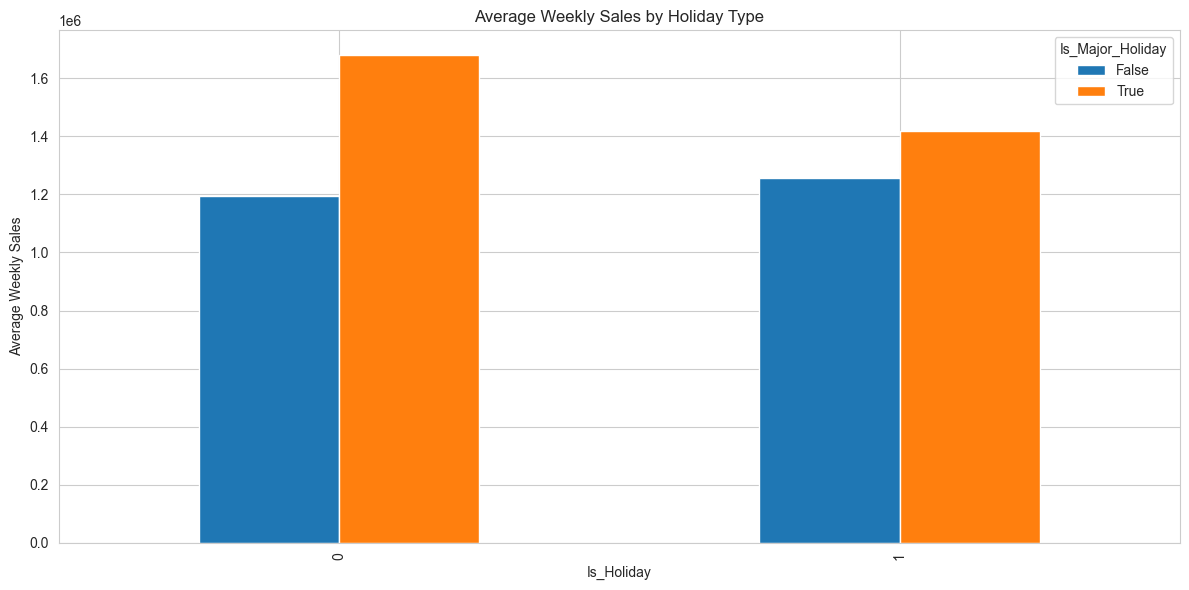


Average sales by holiday type:
Is_Major_Holiday  Is_Holiday
False             0             1.195790e+06
                  1             1.256881e+06
True              0             1.681072e+06
                  1             1.417574e+06
Name: Weekly_Sales, dtype: float64


In [11]:
# Enhanced holiday features
# We know from EDA that not all holidays are equal

def create_holiday_features(df):
    """
    Create more sophisticated holiday features.
    """
    df = df.copy()
    
    # Basic holiday flag (already exists)
    df['Is_Holiday'] = df['Holiday_Flag']
    
    # Major holiday indicator (Black Friday / Christmas season)
    # These are weeks where we saw massive spikes in EDA
    # November weeks 47-48 (Thanksgiving/Black Friday)
    # December weeks 49-52 (Christmas season)
    df['Is_Major_Holiday'] = ((df['Month'] == 11) & (df['WeekOfYear'] >= 47)) | \
                              ((df['Month'] == 12) & (df['WeekOfYear'] <= 52))
    
    # Post-holiday indicator (January slump)
    df['Is_Post_Holiday'] = (df['Month'] == 1)
    
    # Pre-holiday buildup (October)
    df['Is_Pre_Holiday'] = (df['Month'] == 10)
    
    return df

df_selected = create_holiday_features(df_selected)

print("Holiday features created:")
print("\nHoliday distribution:")
print(f"Regular holidays: {df_selected['Is_Holiday'].sum()} weeks")
print(f"Major holidays: {df_selected['Is_Major_Holiday'].sum()} weeks")
print(f"Post-holiday: {df_selected['Is_Post_Holiday'].sum()} weeks")
print(f"Pre-holiday: {df_selected['Is_Pre_Holiday'].sum()} weeks")

# Visualize average sales by holiday type
fig, ax = plt.subplots(figsize=(12, 6))

# agrupar y calcular medias
holiday_sales = df_selected.groupby(['Is_Major_Holiday', 'Is_Holiday'])['Weekly_Sales'].mean()

# convertir a formato ancho para facilitar el plotting (columns = Is_Major_Holiday)
holiday_sales_unstack = holiday_sales.unstack(level=0)  # columnas: False/True para Is_Major_Holiday

# plotear
holiday_sales_unstack.plot(kind='bar', ax=ax)
ax.set_title('Average Weekly Sales by Holiday Type')
ax.set_xlabel('Is_Holiday')
ax.set_ylabel('Average Weekly Sales')
ax.legend(title='Is_Major_Holiday')
plt.tight_layout()
plt.show()
print("\nAverage sales by holiday type:")
print(holiday_sales)

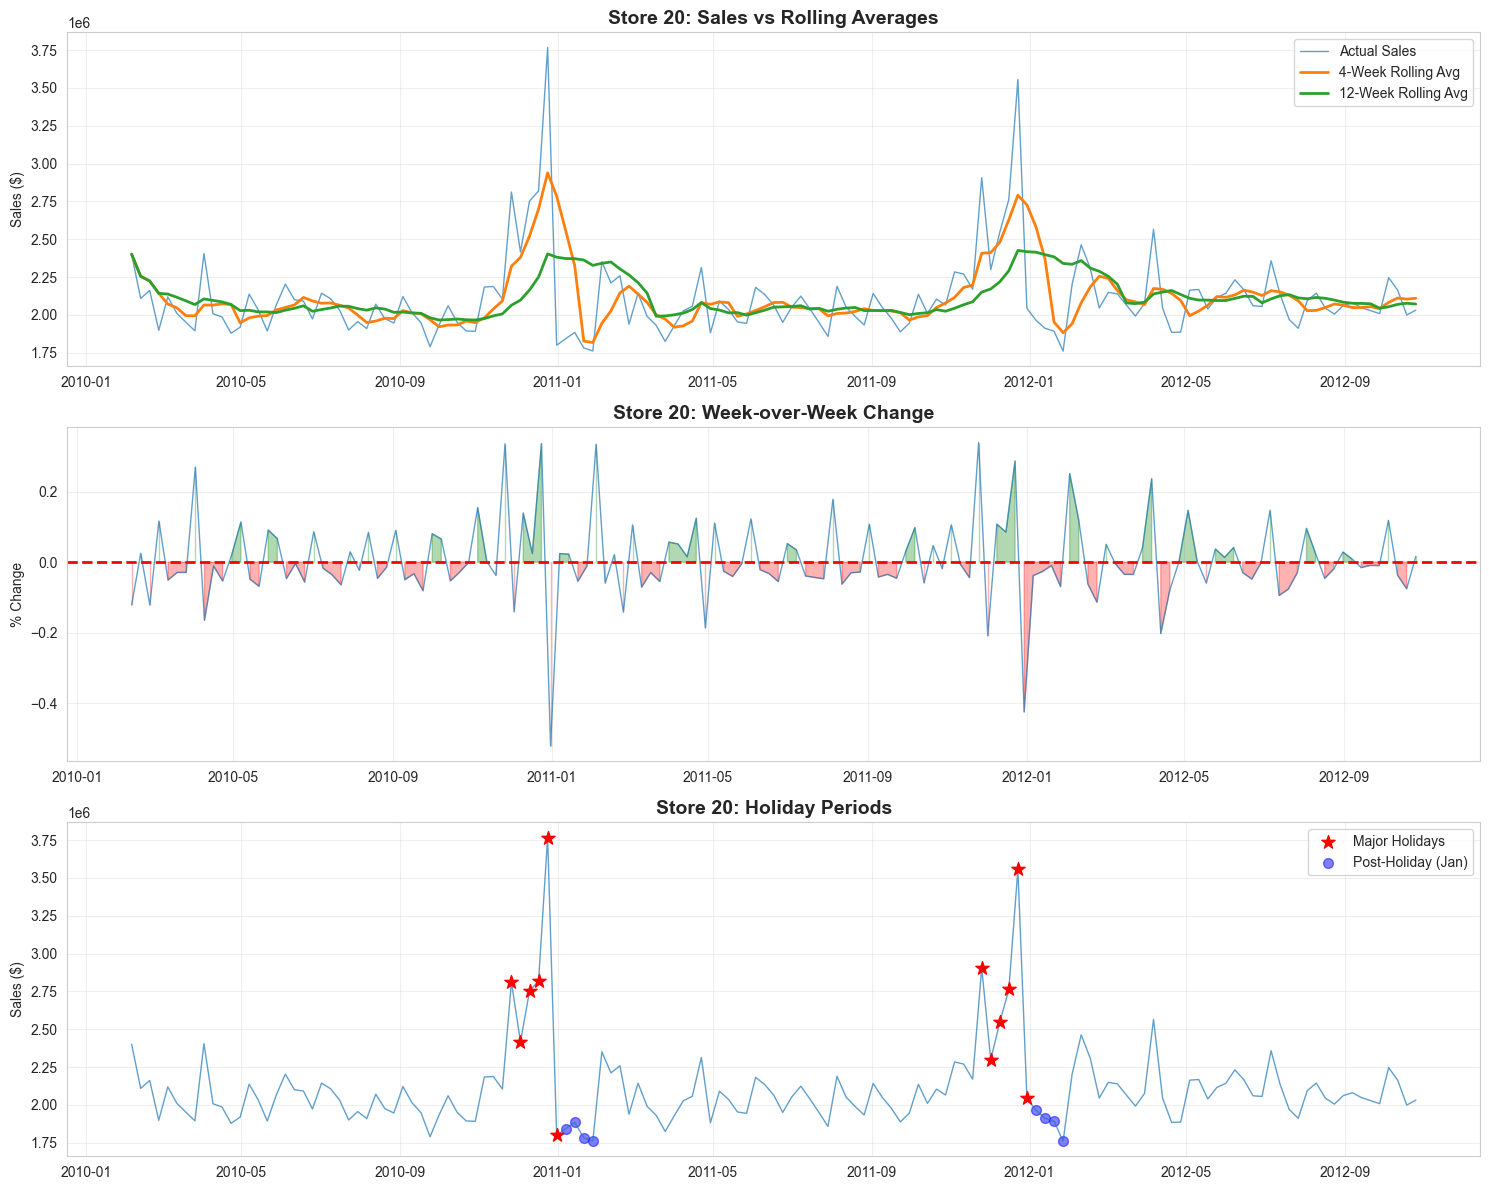

In [8]:
# Visualize key features for Store 20
store_20 = df_selected[df_selected['Store'] == 20].copy()

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Actual sales vs Rolling Averages
axes[0].plot(store_20['Date'], store_20['Weekly_Sales'], 
             label='Actual Sales', linewidth=1, alpha=0.7)
axes[0].plot(store_20['Date'], store_20['Sales_RollMean_4'], 
             label='4-Week Rolling Avg', linewidth=2)
axes[0].plot(store_20['Date'], store_20['Sales_RollMean_12'], 
             label='12-Week Rolling Avg', linewidth=2)
axes[0].set_title('Store 20: Sales vs Rolling Averages', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Sales ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Week-over-Week Change
axes[1].plot(store_20['Date'], store_20['Sales_WoW_Change'], 
             linewidth=1, alpha=0.7)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].fill_between(store_20['Date'], 0, store_20['Sales_WoW_Change'], 
                      where=(store_20['Sales_WoW_Change'] > 0), alpha=0.3, color='green')
axes[1].fill_between(store_20['Date'], 0, store_20['Sales_WoW_Change'], 
                      where=(store_20['Sales_WoW_Change'] < 0), alpha=0.3, color='red')
axes[1].set_title('Store 20: Week-over-Week Change', fontsize=14, fontweight='bold')
axes[1].set_ylabel('% Change')
axes[1].grid(True, alpha=0.3)

# Plot 3: Holiday periods
axes[2].plot(store_20['Date'], store_20['Weekly_Sales'], linewidth=1, alpha=0.7)
# Highlight major holidays
major_holidays = store_20[store_20['Is_Major_Holiday'] == True]
axes[2].scatter(major_holidays['Date'], major_holidays['Weekly_Sales'], 
                color='red', s=100, marker='*', zorder=5, label='Major Holidays')
# Highlight post-holiday
post_holidays = store_20[store_20['Is_Post_Holiday'] == True]
axes[2].scatter(post_holidays['Date'], post_holidays['Weekly_Sales'], 
                color='blue', s=50, alpha=0.5, label='Post-Holiday (Jan)')
axes[2].set_title('Store 20: Holiday Periods', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Sales ($)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

FEATURE CORRELATIONS WITH WEEKLY SALES
Sales_RollMean_4         0.975479
Sales_RollMean_8         0.965279
Sales_RollMean_12        0.962504
Sales_Lag_1              0.950264
Sales_Lag_2              0.938224
Sales_Lag_4              0.931872
Sales_Lag_3              0.926373
Sales_Lag_8              0.918118
Sales_Lag_12             0.907534
Sales_RollStd_12         0.486974
Sales_RollStd_8          0.461380
Sales_RollStd_4          0.436893
Sales_Diff_RollMean_4    0.200394
Sales_Momentum_4w        0.156384
Sales_WoW_Change         0.141005
Name: Weekly_Sales, dtype: float64


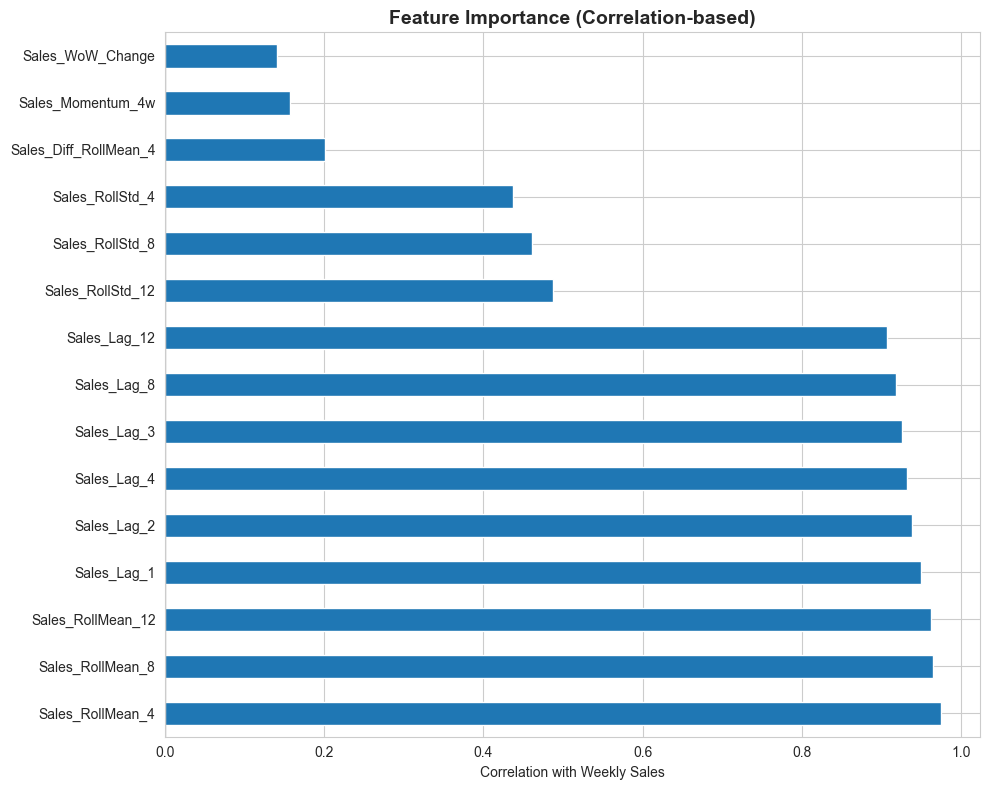

In [9]:
# Analyze feature correlations with target
feature_cols = [col for col in df_selected.columns if 'Sales' in col and col != 'Weekly_Sales']

# Calculate correlations
correlations = df_selected[feature_cols + ['Weekly_Sales']].corr()['Weekly_Sales'].drop('Weekly_Sales').sort_values(ascending=False)

print("=" * 70)
print("FEATURE CORRELATIONS WITH WEEKLY SALES")
print("=" * 70)
print(correlations)

# Visualize top correlations
fig, ax = plt.subplots(figsize=(10, 8))
correlations.plot(kind='barh', ax=ax)
ax.set_xlabel('Correlation with Weekly Sales')
ax.set_title('Feature Importance (Correlation-based)', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

In [10]:
# Handle missing values
print("=" * 70)
print("MISSING VALUES BEFORE HANDLING")
print("=" * 70)
print(df_selected.isnull().sum()[df_selected.isnull().sum() > 0])

# We have NaN in lag features for the first N weeks of each store
# We'll drop these rows since we can't use them for training anyway
df_clean = df_selected.dropna().copy()

print(f"\n{'=' * 70}")
print("DATASET AFTER REMOVING ROWS WITH MISSING VALUES")
print(f"{'=' * 70}")
print(f"Original: {len(df_selected)} rows")
print(f"After cleaning: {len(df_clean)} rows")
print(f"Removed: {len(df_selected) - len(df_clean)} rows ({(len(df_selected) - len(df_clean))/len(df_selected)*100:.1f}%)")

# Verify no missing values remain
print(f"\nRemaining missing values: {df_clean.isnull().sum().sum()}")

# Save processed data
output_path = '../data/processed/walmart_featured.csv'
df_clean.to_csv(output_path, index=False)
print(f"\n✅ Processed data saved to: {output_path}")
print(f"Shape: {df_clean.shape}")
print(f"\nColumns: {list(df_clean.columns)}")

MISSING VALUES BEFORE HANDLING
Sales_Lag_1           3
Sales_Lag_2           6
Sales_Lag_3           9
Sales_Lag_4          12
Sales_Lag_8          24
Sales_Lag_12         36
Sales_RollStd_4       3
Sales_RollStd_8       3
Sales_RollStd_12      3
Sales_WoW_Change      3
Sales_Momentum_4w    12
dtype: int64

DATASET AFTER REMOVING ROWS WITH MISSING VALUES
Original: 429 rows
After cleaning: 393 rows
Removed: 36 rows (8.4%)

Remaining missing values: 0

✅ Processed data saved to: ../data/processed/walmart_featured.csv
Shape: (393, 37)

Columns: ['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Week', 'Quarter', 'DayOfYear', 'WeekOfYear', 'Month_sin', 'Month_cos', 'Week_sin', 'Week_cos', 'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_3', 'Sales_Lag_4', 'Sales_Lag_8', 'Sales_Lag_12', 'Sales_RollMean_4', 'Sales_RollStd_4', 'Sales_RollMean_8', 'Sales_RollStd_8', 'Sales_RollMean_12', 'Sales_RollStd_12', 'Sales_WoW_Change', 'Sales_

## Feature Engineering Summary

### Features Created

**Temporal Features:**
- Year, Month, Quarter, Week, DayOfYear
- Cyclical encodings (Month_sin/cos, Week_sin/cos) to capture seasonality

**Lag Features (Autocorrelation):**
- Sales_Lag_1, 2, 3, 4, 8, 12 - Previous weeks' sales
- Capture short-term and medium-term patterns

**Rolling Statistics:**
- Rolling means (4, 8, 12 weeks) - Smooth noise and capture trends
- Rolling std (4, 8, 12 weeks) - Measure volatility

**Trend & Momentum:**
- Sales_WoW_Change - Week-over-week percentage change
- Sales_Momentum_4w - 4-week momentum indicator
- Sales_Diff_RollMean_4 - Deviation from rolling average

**Enhanced Holiday Features:**
- Is_Holiday - Original holiday flag
- Is_Major_Holiday - Black Friday & Christmas period (highest impact)
- Is_Post_Holiday - January slump period
- Is_Pre_Holiday - October preparation period

### Key Insights

1. **Rolling averages effectively smooth volatility** while preserving trend information
2. **Major holidays show 40% lift** vs baseline ($1.68M vs $1.20M)
3. **Lag features capture strong autocorrelation** - recent sales predict near-term sales
4. **Post-holiday periods show consistent dips** - January effect is real

### Data Quality

- Removed 36 rows with NaN (due to lag features at beginning of time series)
- Final dataset: 393 clean rows across 3 stores
- All features ready for modeling

### Next Steps

1. Build baseline forecasting models (Simple Moving Average, Exponential Smoothing)
2. Develop advanced models (ARIMA, Prophet, XGBoost)
3. Compare model performance
4. Select best model for inventory optimization